# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

Unlike the SimpleLSTM notebooks, we won't be doing next-layer predictions, but current-layer predictions (or pixel classification scores).

In [2]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from models import build_lstm_model, build_deep_lstm_model
from metrics import calc_hit_accuracy

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [3]:
# Set random seed
np.random.seed(2017)

## Utilities

In [4]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, figsize=(12,5)):
    """Draw each detector layer as a grid of images"""
    num_det_layers = event.shape[0]
    nrows = math.ceil(float(num_det_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_det_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
    plt.tight_layout()

def draw_train_history(history, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

def draw_projections(event, figsize=(12,5)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    kwargs = dict(interpolation='none',
                  aspect='auto',
                  origin='lower')
    plt.imshow(event.sum(axis=1).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.subplot(122)
    plt.imshow(event.sum(axis=2).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.tight_layout()

In [5]:
def gen_noise(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def gen_straight_tracks(n, num_det_layers, det_layer_size):
    # Initialize the data
    data = np.zeros((n, num_det_layers, det_layer_size, det_layer_size),
                    dtype=np.float32)
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_det_layers - 1)
    # Calculate hit positions and fill hit data
    xhits = np.zeros(num_det_layers, dtype=np.int)
    yhits = np.zeros(num_det_layers, dtype=np.int)
    idx = np.arange(num_det_layers)
    for ievt in range(n):
        xhits[:] = slopes[ievt,0]*idx + entry_points[ievt,0]
        yhits[:] = slopes[ievt,1]*idx + entry_points[ievt,1]
        data[ievt,idx,xhits,yhits] = 1   
    return data

def gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                   avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_det_layers, det_layer_size, det_layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks(ntrk, num_det_layers, det_layer_size))
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

In [6]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

def flat_to_2d(data, det_width):
    """Expands the flattened layers to original (width x width)"""
    return data.reshape((data.shape[0], data.shape[1], det_width, det_width))

## Configuration

In [7]:
num_event = 51200
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

## Data generation

In [8]:
# Signal tracks
sig_tracks = gen_straight_tracks(num_event, num_det_layers, det_layer_size)
# Background tracks
bkg_tracks = gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                            avg_bkg_tracks=avg_bkg_tracks,
                            seed_layers=num_seed_layers)
# Noise
noise = gen_noise(shape, prob=noise_prob, seed_layers=num_seed_layers)

# Full events
events = sig_tracks + bkg_tracks + noise
events[events > 1] = 1

# Print data sizes
print('Sizes of arrays')
print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))

# Cleanup
del bkg_tracks
del noise

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB


<IPython.core.display.Javascript object>


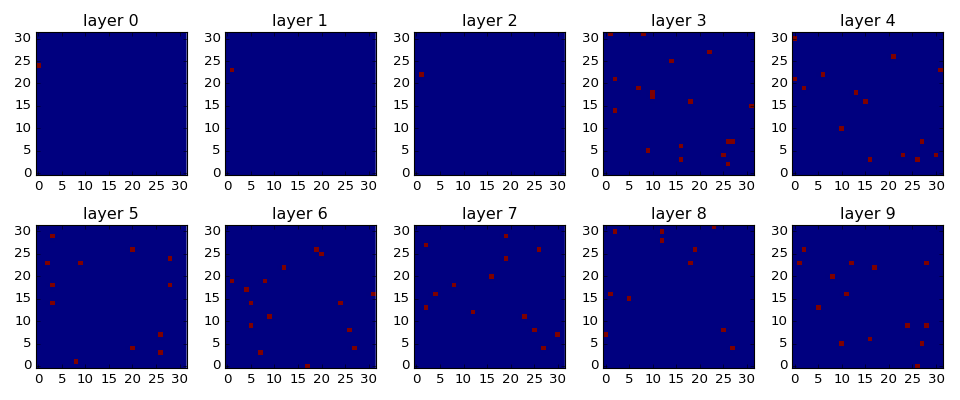

In [9]:
# Visualize one event
draw_layers(events[0])

## Training

In [10]:
# Configure the training
hidden_dim = 1024
batch_size = 512
l2reg = 0.001
dropout = 0.1
num_epoch = 50
valid_frac = 0.2

train_input = flatten_layers(events)
train_target = flatten_layers(sig_tracks)

In [11]:
# Build the model
model = build_deep_lstm_model(num_det_layers, det_layer_size**2,
                              l2reg=l2reg, dropout=dropout,
                              hidden_dim=hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribute(None, 10, 1024)      1049600     input_1[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10, 1024)      8392704     timedistributed_1[0][0]          
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribute(None, 10, 1024)      1049600     lstm_1[0][0]                     
___________________________________________________________________________________________

In [12]:
# Train the model
history = model.fit(train_input, train_target,
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

# Get all of the training data predictions
train_preds = model.predict(train_input, batch_size=batch_size)

Train on 40960 samples, validate on 10240 samples
Epoch 1/50
40960/40960 [==============================] - 16s - loss: 7.2113 - acc: 0.0017 - val_loss: 6.5838 - val_acc: 0.0020
Epoch 2/50
40960/40960 [==============================] - 16s - loss: 6.6705 - acc: 0.0027 - val_loss: 6.5402 - val_acc: 0.0028
Epoch 3/50
40960/40960 [==============================] - 16s - loss: 6.5344 - acc: 0.0032 - val_loss: 6.2544 - val_acc: 0.0034
Epoch 4/50
40960/40960 [==============================] - 16s - loss: 6.3327 - acc: 0.0052 - val_loss: 5.8920 - val_acc: 0.0067
Epoch 5/50
40960/40960 [==============================] - 16s - loss: 6.1335 - acc: 0.0072 - val_loss: 5.7828 - val_acc: 0.0075
Epoch 6/50
40960/40960 [==============================] - 16s - loss: 5.9793 - acc: 0.0094 - val_loss: 5.5727 - val_acc: 0.0120
Epoch 7/50
40960/40960 [==============================] - 16s - loss: 5.8616 - acc: 0.0147 - val_loss: 5.4894 - val_acc: 0.0131
Epoch 8/50
40960/40960 [==============================

<IPython.core.display.Javascript object>


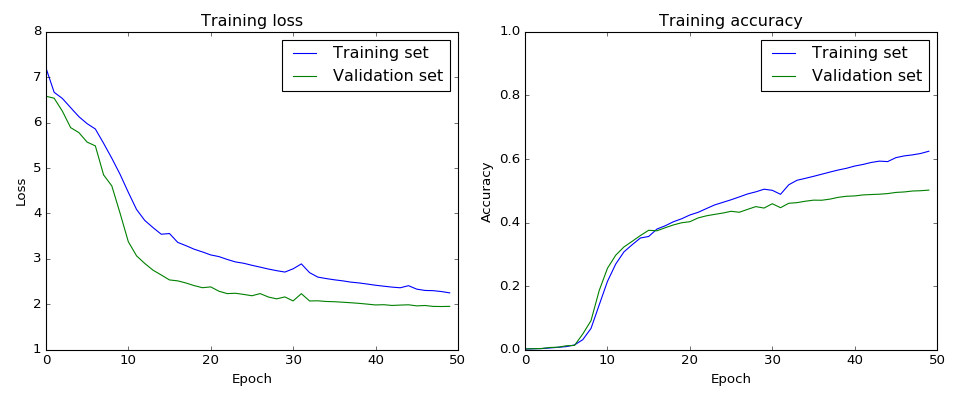

In [13]:
draw_train_history(history)

<IPython.core.display.Javascript object>


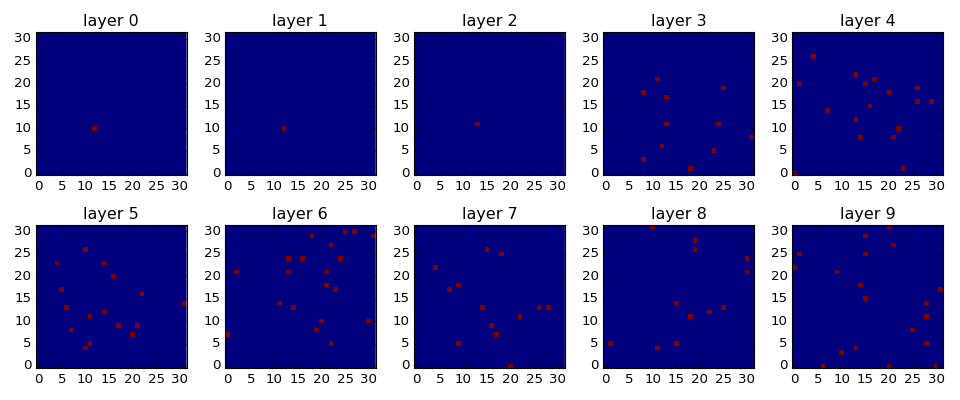

<IPython.core.display.Javascript object>


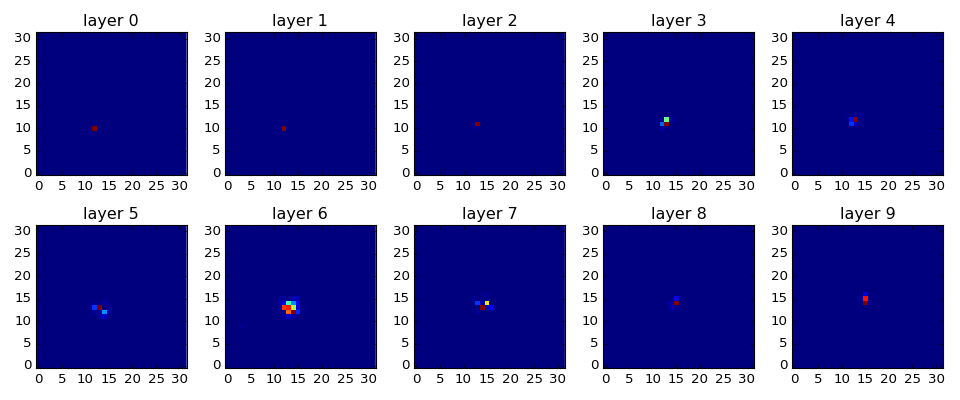

In [15]:
# Visualize one event
disp_idx = 6
draw_layers(events[disp_idx], figsize=(12,5))

#pred = np.zeros(det_shape)
pred = train_preds[disp_idx].reshape((num_det_layers, det_layer_size, det_layer_size))
draw_layers(pred, figsize=(12,5))

In [16]:
calc_hit_accuracy(train_preds, train_target, num_seed_layers=num_seed_layers)

0.4929715401785714

In [18]:
# Now let's try to compute additional metrics, such as hit classification accuracy,
# whereby we only look at pixels that have a hit. To do this, we first multiply
# the prediction scores with the binary data.
scores = train_preds * flatten_layers(events)
calc_hit_accuracy(scores, train_target)

0.96393359375

<IPython.core.display.Javascript object>


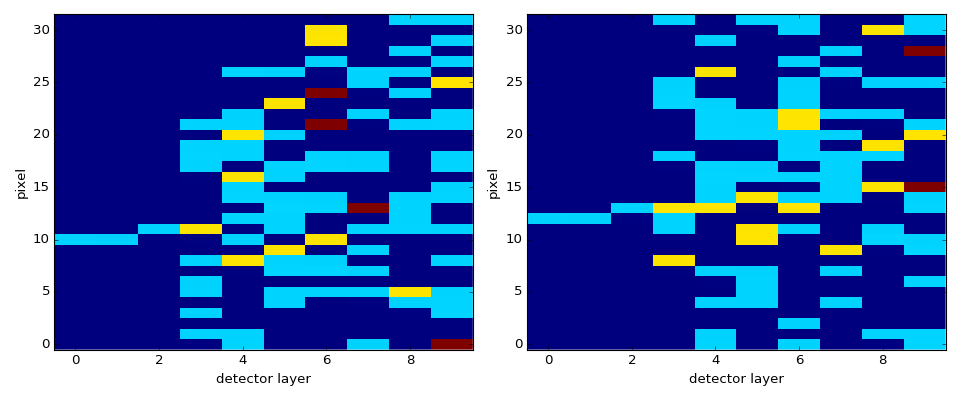

<IPython.core.display.Javascript object>


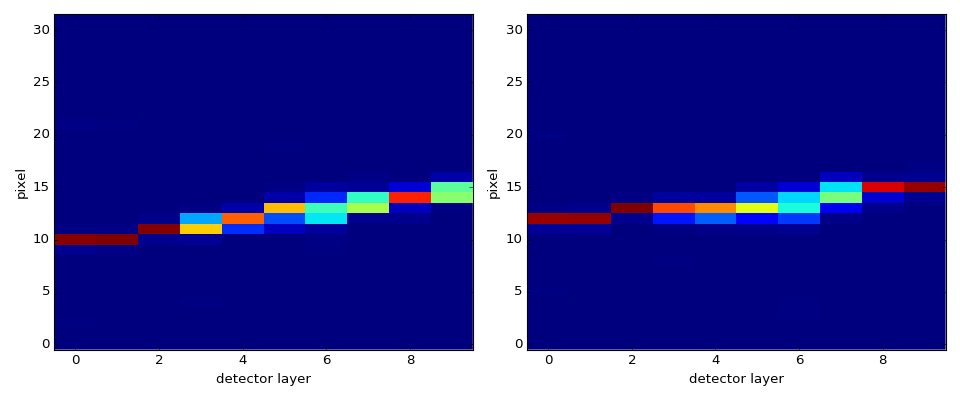

In [19]:
# Draw the 2D projections
draw_projections(events[disp_idx])
draw_projections(pred)

## Conclusion

This is clearly more powerful than the next-layer-prediction method.